In [1]:
import pandas as pd
import numpy as np
from scipy import spatial
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon
import fiona
import statistics
import contextily as cx

In [2]:
mypath = '/home/selihadji/Documenti/papers/Platoon_II/trips/'

In [3]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [4]:
def filterSubstr(lists, substr):
    return [x for x in lists if substr in x]

searchString = '2022_09_14'
onlyfiles_14_09 = filterSubstr(onlyfiles, searchString)
onlyfiles_14_09

searchString1 = '09_10_09'
onlyfiles1 = filterSubstr(onlyfiles_14_09, searchString1)
onlyfiles1

searchString2 = '09_11_09'
onlyfiles2 = filterSubstr(onlyfiles_14_09, searchString2)
onlyfiles = onlyfiles1 + onlyfiles2
onlyfiles

['2022_09_14_LA2 Logi Jeep_09_10_09_29_289298c8-ecf5-4092-b17a-21cba488a2c2.csv',
 '2022_09_14_RG Logi Jeep_09_10_09_29_79e3a673-0e1c-49ab-bc4a-c2c8f2640186.csv',
 '2022_09_14_PS Skylark Test_09_11_09_29_ae072aae-9ada-475a-a8ea-63fefd4f04a5.csv']

In [5]:
allfiles = []
for i in range(len(onlyfiles)):
    df = pd.read_csv(mypath + str(onlyfiles[i]), sep=';', decimal=',')
    df['Time[ms]'] = pd.to_datetime(df['Time[ms]'], unit='ms')
    df['driver'] = str(onlyfiles[i])[11:13]
    coord_ = [Point(x, y) for x, y in zip(df.Longitude, df.Latitude)]
    alldata_ = gpd.GeoDataFrame(df, geometry=coord_, crs ="EPSG:4326")
    allfiles.append(df)
alldata = pd.concat(allfiles, axis=0).reset_index(drop=True)

In [6]:
alldata['data'] = alldata['Time[ms]'].dt.date

In [7]:
alldata["data"] = pd.to_datetime(alldata["data"])

In [8]:
alldata_RG = alldata[alldata.driver == 'RG']
alldata_PS = alldata[alldata.driver == 'PS']
alldata_LA = alldata[alldata.driver == 'LA']

In [9]:
allfiles = []
for i in range(len(onlyfiles)):
    df = pd.read_csv(mypath + str(onlyfiles[i]), sep=';', decimal=',')
    df['Time[ms]'] = pd.to_datetime(df['Time[ms]'], unit='ms')
    df['driver'] = str(onlyfiles[i])[11:13]
    coord_ = [Point(x, y) for x, y in zip(df.Longitude, df.Latitude)]
    alldata_ = gpd.GeoDataFrame(df, geometry=coord_, crs ="EPSG:4326")
    allfiles.append(df)

In [10]:
alldata = pd.concat(allfiles, axis=0).reset_index(drop=True)

In [11]:
alldata.driver.unique()

array(['LA', 'RG', 'PS'], dtype=object)

In [12]:
alldata_SORTED = alldata.sort_values(by = 'Time[ms]').reset_index(drop=True)

In [13]:
alldata_SORTED_cut = alldata_SORTED.iloc[100:,:].dropna().reset_index(drop=True)

In [14]:
alldata_SORTED_cut['Time'] = pd.to_datetime(alldata_SORTED_cut['Time[ms]'].dt.strftime('%H:%M:%S'))

In [15]:
rg = alldata_SORTED_cut[alldata_SORTED_cut.driver == 'RG'].reset_index(drop=True).drop_duplicates()
la = alldata_SORTED_cut[alldata_SORTED_cut.driver == 'LA'].reset_index(drop=True).drop_duplicates()
ps = alldata_SORTED_cut[alldata_SORTED_cut.driver == 'PS'].reset_index(drop=True).drop_duplicates()

In [16]:
from haversine import haversine, Unit
import haversine as hs

In [17]:
platoon_alldist = []
platoon_all_CO2 = []

platoon_all_lat_dist = []
platoon_all_lon_dist = []

platoon_all_lat_CO2 = []
platoon_all_lon_CO2 = []

#ps --> rg
#jc --> la
#dw --> ps


for i in range(len(rg)):
    platoon_lat_dist = []
    platoon_lon_dist = []
    platoon_lat_CO2 = []
    platoon_lon_CO2 = []
    platoon_dist = []
    CO2_max = []
    dist_mat = []
    
    rg_ = rg.iloc[i]
    
    df_array1 = (rg_.Latitude, rg_.Longitude)

    la_ = la[la['Time'] > rg_['Time']].reset_index(drop=True)
    df_array2 = list(zip(la_.Latitude, la_.Longitude))[0:60]
        
    for j in range(len(df_array2)):
        dist_mat.append(hs.haversine(df_array1,df_array2[j],unit=Unit.METERS))

    la_mindist = min(dist_mat)
    la_mindist_index = dist_mat.index(la_mindist)

    platoon_dist.append(la_mindist)

    platoon_lat_dist.append(la_.iloc[la_mindist_index]["Latitude"])
    platoon_lon_dist.append(la_.iloc[la_mindist_index]["Longitude"])

    CO2 = []
    CO2.append(la_.iloc[0]['CO2[kg]'])
    try:
        CO2.extend(list(la_.iloc[1:21]['CO2[kg]']))
    except:
        pass
    
    la_maxCO2 = max(CO2)
    la_maxCO2_index = CO2.index(la_maxCO2)
    CO2_max.append(la_.reset_index(drop=True).iloc[la_maxCO2_index]['CO2[kg]'])
    platoon_lat_CO2.append(la_.reset_index(drop=True).iloc[la_maxCO2_index]["Latitude"])
    platoon_lon_CO2.append(la_.reset_index(drop=True).iloc[la_maxCO2_index]["Longitude"])    


    ps_ = ps[ps['Time'] > la_['Time'][la_mindist_index]].reset_index(drop=True)
    df_array3 = list(zip(ps_.Latitude, ps_.Longitude))[0:60]        
    
    dist_mat = []

    for j in range(len(df_array3)):
        dist_mat.append(hs.haversine(df_array2[la_mindist_index],df_array3[j],unit=Unit.METERS))

    ps_mindist = min(dist_mat)
    ps_mindist_index = dist_mat.index(ps_mindist)

    platoon_dist.append(ps_mindist)
    platoon_lat_dist.append(ps_.reset_index(drop=True).iloc[ps_mindist_index]["Latitude"])
    platoon_lon_dist.append(ps_.reset_index(drop=True).iloc[ps_mindist_index]["Longitude"])    

    CO2 = []

    CO2.append(ps_.iloc[0]['CO2[kg]'])
    try:
        CO2.extend(list(ps_.iloc[1:21]['CO2[kg]']))
    except:
        pass
    ps_maxCO2 = max(CO2)
    ps_maxCO2_index = CO2.index(ps_maxCO2)
    CO2_max.append(ps_.reset_index(drop=True).iloc[ps_maxCO2_index]['CO2[kg]'])
    platoon_lat_CO2.append(ps_.reset_index(drop=True).iloc[ps_maxCO2_index]["Latitude"])
    platoon_lon_CO2.append(ps_.reset_index(drop=True).iloc[ps_maxCO2_index]["Longitude"])  

      
    platoon_all_lat_dist.append(platoon_lat_dist)
    platoon_all_lon_dist.append(platoon_lon_dist)
    platoon_all_lat_CO2.append(platoon_lat_CO2)
    platoon_all_lon_CO2.append(platoon_lon_CO2)
    platoon_alldist.append(platoon_dist)
    platoon_all_CO2.append(CO2_max)

ValueError: min() arg is an empty sequence

<Axes: >

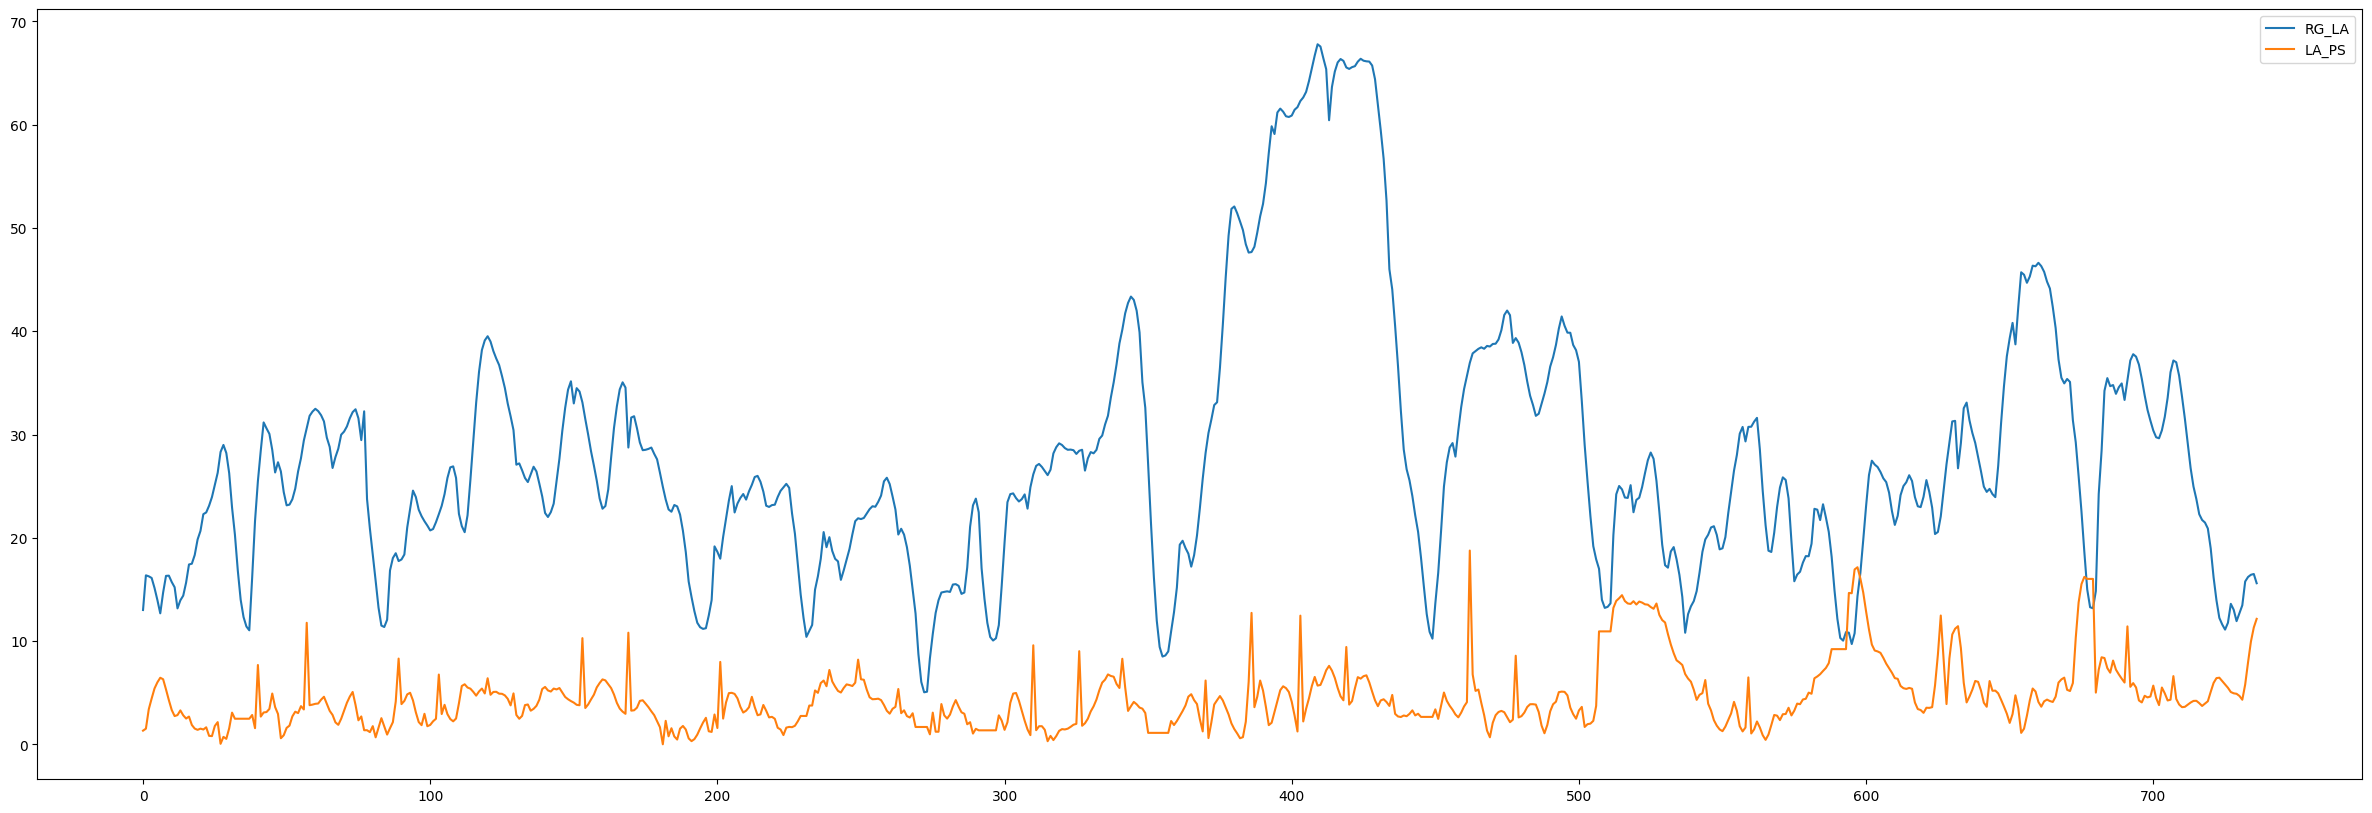

In [19]:
pd.DataFrame(platoon_alldist, columns = ['RG_LA', 'LA_PS']).plot(figsize=(30,10))

In [20]:
dist_v = pd.DataFrame(platoon_alldist, columns = ['RG_LA', 'LA_PS'])
pd.DataFrame(platoon_alldist, columns = ['RG_LA', 'LA_PS']).to_csv('distance_platoon.csv', index=False)

In [21]:
dist_coord = pd.concat([pd.DataFrame(platoon_all_lat_dist, columns=['v1_lat', 'v2_lat'])['v1_lat'], pd.DataFrame(platoon_all_lon_dist, columns=['v1_lon', 'v2_lon'])['v1_lon'],pd.DataFrame(platoon_all_lat_dist, columns=['v1_lat', 'v2_lat'])['v2_lat'], pd.DataFrame(platoon_all_lon_dist, columns=['v1_lon', 'v2_lon'])['v2_lon']], axis=1)

In [22]:
pd.concat([pd.DataFrame(platoon_all_lat_dist, columns=['v1_lat', 'v2_lat'])['v1_lat'], pd.DataFrame(platoon_all_lon_dist, columns=['v1_lon', 'v2_lon'])['v1_lon'],pd.DataFrame(platoon_all_lat_dist, columns=['v1_lat', 'v2_lat'])['v2_lat'], pd.DataFrame(platoon_all_lon_dist, columns=['v1_lon', 'v2_lon'])['v2_lon']], axis=1).to_csv('platoon_distances_coord.csv', index=False)

In [23]:
infr = pd.read_csv('/home/selihadji/Documenti/papers/Platoon_II/infrast_data_update_.csv', sep=';')
infr.what.unique()

array(['Turn_left', '4-ways intersection', 'Traffic_light', 'Curve',
       'Road_immission', 'Turn_right'], dtype=object)

In [24]:
allveic = []
for k in range(0, len(dist_coord.columns)-1, 2):
    veic = []
    for i in range(len(dist_coord)):
        infra = []
        for j in range(len(infr)):
            inf = (infr.iloc[j].lon,infr.iloc[j].lat)
            distcoor = (dist_coord.iloc[i][str(dist_coord.columns[k+1])], dist_coord.iloc[i][str(dist_coord.columns[k])])
            infra.append(hs.haversine(inf,distcoor,unit=Unit.METERS))
        veic.append(infra)
    allveic.append(veic)

In [25]:
v1 = pd.DataFrame(allveic[0])
v2 = pd.DataFrame(allveic[1])

In [26]:
allfeat = []
for i in range(len(v1)): 
    allfeat.append(list(v1[v1<500].iloc[i].dropna()))
new_v1 = pd.DataFrame(allfeat).iloc[:,0:7].fillna(0)

In [27]:
allfeat = []
for i in range(len(v2)): 
    allfeat.append(list(v2[v2<500].iloc[i].dropna()))
new_v2 = pd.DataFrame(allfeat).iloc[:,0:7].fillna(0)

In [28]:
v1.columns = infr.what
v2.columns = infr.what

In [29]:
vlist = []
vlist.append(v1)
vlist.append(v2)

In [30]:
import statsmodels.api as sm

In [31]:
all_X = []
all_y = []

for k in range(len(vlist)):
    feats = []
    v = vlist[k]
    infrast = v.idxmin(axis=1)
    for i in range(len(v)):
        if (v.iloc[i][str(infrast[i])] < 80).any():
            feats.append([infrast[i]])
        else:
            feats.append([])
    new_v = pd.get_dummies(pd.DataFrame(feats), prefix='Feat')

    X = new_v.copy()
    y = dist_v[str(dist_v.columns[k])]
    X['old_dist'] = dist_v[str(dist_v.columns[k])].shift(10).fillna(0)
    all_X.append(X)
    all_y.append(y)

all_X_ = pd.concat(all_X).reset_index(drop=True).fillna(0)
all_y_ = pd.concat(all_y).reset_index(drop=True).fillna(0)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  LA_PS   R-squared (uncentered):                   0.681
Model:                            OLS   Adj. R-squared (uncentered):              0.678
Method:                 Least Squares   F-statistic:                              223.0
Date:                Tue, 01 Aug 2023   Prob (F-statistic):                   1.59e-176
Time:                        09:06:53   Log-Likelihood:                         -1882.7
No. Observations:                 737   AIC:                                      3779.
Df Residuals:                     730   BIC:                                      3812.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Feat_4-ways intersection    -0.1162      0.580     -0.200      0.841      -1.256       1.023
Feat_Curve                   2.7808      0.552      5.037      0.000       1.697       3.865
Feat_Road_immission          1.4077      0.580      2.429      0.015       0.270       2.546
Feat_Traffic_light           1.3249      0.206      6.430      0.000       0.920       1.729
Feat_Turn_left               2.1960      0.609      3.604      0.000       1.000       3.392
Feat_Turn_right              1.6866      0.511      3.301      0.001       0.684       2.690
old_dist                     0.6568      0.031     21.099      0.000       0.596       0.718
==============================================================================
Omnibus:                      187.190   Durbin-Watson:                   0.534
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              504.177
Skew:                           1.277   Prob(JB):                    3.31e-110
Kurtosis:                       6.146   Cond. No.                         30.4
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
results_summary = model.summary()
df = pd.DataFrame.from_records(results_summary.tables[1].data)
header = df.iloc[0]
df = df[1:] # take the data less the header row
df.columns = header
df.to_csv('platoon_II_14_09_09_10.csv')

In [33]:
platoon_all_CO2_ = pd.DataFrame(platoon_all_CO2, columns = ['RW_LA', 'LA_PS'])
pd.DataFrame(platoon_all_CO2, columns = ['RW_LA', 'LA_PS']).to_csv('CO2_platoon.csv', index=False)

all_X = []
all_y = []

for k in range(len(vlist)):
    feats = []
    v = vlist[k]
    infrast = v.idxmin(axis=1)
    for i in range(len(v)):
        if (v.iloc[i][str(infrast[i])] <80).any():
            feats.append([infrast[i]])
        else:
            feats.append([])
    new_v = pd.get_dummies(pd.DataFrame(feats), prefix='Feat')

    X = new_v.copy()
    y = platoon_all_CO2_[str(platoon_all_CO2_.columns[k])]
    X['old_dist'] = dist_v[str(dist_v.columns[k])].shift(10).fillna(0)
    all_X.append(X)
    all_y.append(y)

all_X_ = pd.concat(all_X).reset_index(drop=True).fillna(0)
all_y_ = pd.concat(all_y).reset_index(drop=True).fillna(0)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  LA_PS   R-squared (uncentered):                   0.520
Model:                            OLS   Adj. R-squared (uncentered):              0.515
Method:                 Least Squares   F-statistic:                              112.9
Date:                Tue, 01 Aug 2023   Prob (F-statistic):                   7.17e-112
Time:                        09:06:54   Log-Likelihood:                          2949.5
No. Observations:                 737   AIC:                                     -5885.
Df Residuals:                     730   BIC:                                     -5853.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Feat_4-ways intersection     0.0028      0.001      3.426      0.001       0.001       0.004
Feat_Curve                   0.0013      0.001      1.695      0.091      -0.000       0.003
Feat_Road_immission          0.0012      0.001      1.515      0.130      -0.000       0.003
Feat_Traffic_light           0.0035      0.000     12.023      0.000       0.003       0.004
Feat_Turn_left               0.0024      0.001      2.722      0.007       0.001       0.004
Feat_Turn_right              0.0045      0.001      6.255      0.000       0.003       0.006
old_dist                     0.0004   4.42e-05      8.196      0.000       0.000       0.000
==============================================================================
Omnibus:                      275.679   Durbin-Watson:                   0.142
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1094.648
Skew:                           1.728   Prob(JB):                    2.00e-238
Kurtosis:                       7.868   Cond. No.                         30.4
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
results_summary = model.summary()
df = pd.DataFrame.from_records(results_summary.tables[1].data)
header = df.iloc[0]
df = df[1:] # take the data less the header row
df.columns = header
df.to_csv('platoon_II_14_09_09_10_CO2.csv')